### Set up

#### 1. Set  up  accounts and role

In [26]:
import sagemaker
import boto3
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('./src')


sagemaker_session = sagemaker.Session()
account_id =  boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name


#role = sagemaker.get_execution_role()
role="arn:aws:iam::{}:role/service-role/AmazonSageMaker-ExecutionRole-20190118T115449".format(account_id)


#### 2. Setup image and instance type

In [2]:
pytorch_custom_image_name="image-embedding:gpu-1.0.0-201909170217"
instance_type = "ml.p3.2xlarge" 
docker_repo = "{}.dkr.ecr.{}.amazonaws.com/{}".format(account_id, region, pytorch_custom_image_name)

#### 3. Configure train/ test and validation datasets

In [3]:
bucket = sagemaker_session.default_bucket()
raw_bucket="aegovansagemaker"

In [33]:
s3_train_raw = "s3://{}/merket1501/bounding_box_train/".format(raw_bucket)

In [83]:
s3_train="s3://{}/market1501/train3/".format(bucket)
s3_train_lst="s3://{}/market1501/train3_lst/".format(bucket)


s3_val="s3://{}/market1501/val3/".format(bucket)
s3_val_lst="s3://{}/market1501/val3_lst/".format(bucket)


s3_output_path= "s3://{}/market1501_output/".format(bucket)

## Split train test

In [22]:
temp_dir="/tmp/imageebedding"
train_raw_dir = os.path.join(temp_dir, "train_raw")
train_lst= os.path.join(temp_dir, "train_raw", "train.lst")
val_raw_dir = os.path.join(temp_dir, "val_raw")
val_lst= os.path.join(temp_dir, "val_raw", "val.lst")




In [47]:
!rm -rf $temp_dir 
!mkdir  -p $temp_dir 
!mkdir -p  $train_raw_dir
!mkdir -p  $val_raw_dir
!aws s3 sync $s3_train_raw $train_raw_dir --quiet

In [49]:
from datasets.market1501_dataset import Market1501Dataset

dataset = Market1501Dataset(train_raw_dir)

In [50]:
files = [os.path.join(train_raw_dir, f) for f in os.listdir(train_raw_dir) if f.endswith(".jpg")]

# The market 1501 dataset files have the naming convention target_camerasite_..., e.g. 1038_c2s2_131202_03.jpeg
target_raw_labels = [os.path.basename(f).split("_")[0] for f in files]
zero_indexed_labels_dict = {}
for rc in target_raw_labels:
    zero_indexed_labels_dict[rc] = zero_indexed_labels_dict.get(rc, len(zero_indexed_labels_dict))

target_zero_indexed_labels = [zero_indexed_labels_dict[l] for l in target_raw_labels]

In [51]:
#s3://sagemaker-us-east-2-324346001917/market1501/train/
len(zero_indexed_labels_dict)

751

In [52]:
from sklearn.model_selection import train_test_split

class_train, class_val = train_test_split( list(zero_indexed_labels_dict.values()),  test_size=0.20, random_state=42)

In [55]:
datatrain_x = [f for f,l in zip(files, target_zero_indexed_labels) if l in class_train]
datatrain_y = [l for f,l in zip(files, target_zero_indexed_labels) if l in class_train]


dataval_x = [f for f,l in zip(files, target_zero_indexed_labels) if l in class_val]
dataval_y = [l for f,l in zip(files, target_zero_indexed_labels) if l in class_val]

In [56]:
df_val = pd.DataFrame.from_records([(i,)for i in dataval_y])
df_val.columns=["target"]
df_train = pd.DataFrame.from_records([(i,)for i in datatrain_y])
df_train.columns=["target"]

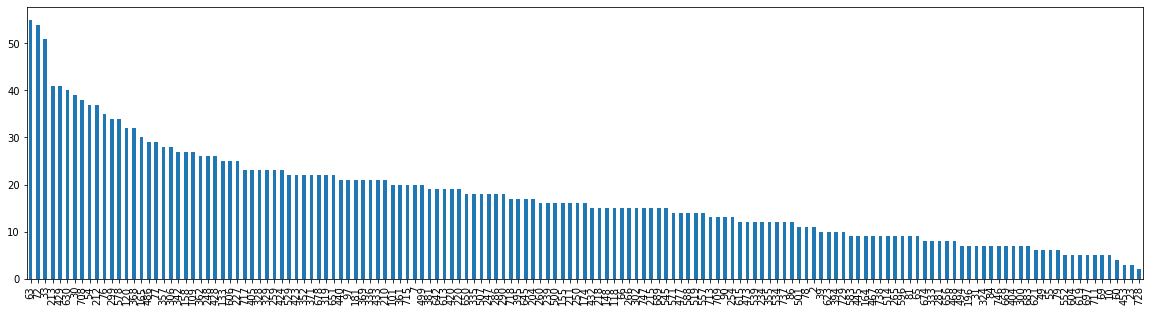

In [57]:
df_val["target"].value_counts().plot.bar(figsize=(20,5))

In [62]:
df_val["target"].nunique()

151

In [63]:
df_train["target"].nunique()

600

In [64]:
df_train.shape

(10309, 1)

In [65]:
df_train["target"].describe()

count    10309.000000
mean       358.873412
std        212.583353
min          0.000000
25%        166.000000
50%        359.000000
75%        538.000000
max        750.000000
Name: target, dtype: float64

In [66]:
import boto3
import os
from multiprocessing.dummy import Pool as ThreadPool

s3_client = boto3.client('s3')

def upload_files(files, s3_dest, num_threads=10 ):
    input_tuples = ( (f,  s3_dest) for f in files)

    with ThreadPool(num_threads) as pool:
        pool.starmap(upload_file, input_tuples)
   
    

def upload_file(f, s3_dest):
    fname=os.path.basename(f)
    prefix = "/".join( s3_dest.split("//")[1].split("/")[1:])
    key = "{}/{}".format(prefix.strip("/"), fname)
    bucket_d = s3_dest.split("//")[1].split("/")[0]
    s3_client.upload_file(f,   bucket_d, key)

In [84]:
%%time

upload_files(dataval_x, s3_val)

CPU times: user 14.8 s, sys: 2.68 s, total: 17.5 s
Wall time: 2min 54s


In [85]:
%%time

upload_files(datatrain_x, s3_train)

CPU times: user 53.2 s, sys: 9.62 s, total: 1min 2s
Wall time: 11min 31s


In [ ]:
s3_train, s3_val

A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column should be unique across all of the images. Here we make an image list file using the im2rec tool from MXNet. You can also create the .lst file in your own way. An example of .lst file is shown as follows.

In [74]:
# def create_lst_file(x, y, dest_lst_file):
#     with open(dest_lst_file, "w") as f:
#         for i, (x,y) in enumerate(zip(x, y)):
#             line = "{}\t{}\t{}\n".format(i, y, x)
#             f.write(line)
    

In [75]:
# create_lst_file([x.lstrip(val_raw_dir) for x in dataval_x], dataval_y, val_lst)
# create_lst_file([x.lstrip(train_raw_dir) for x in datatrain_x], datatrain_y, train_lst)

In [76]:
# upload_file(val_lst, s3_val_lst)
# upload_file(train_lst, s3_train_lst)

In [77]:
# !head $train_lst

## Start training

In [86]:
inputs = {
    "train" : s3_train,
    "val" :s3_val
}

In [87]:
hyperparameters = {
    "dataset":"Market1501Factory",
    "batchsize": "256",
    "epochs" : "1000",
    "patience": 20,
    "log-level" : "INFO"
}

In [88]:
metric_definitions = [{"Name": "TrainLoss",
                     "Regex": "###score: train_loss### (\d*[.]?\d*)"}
                    ,{"Name": "ValidationLoss",
                     "Regex": "###score: val_loss### (\d*[.]?\d*)"}
                    ,{"Name": "TrainScore",
                     "Regex": "###score: train_score### (\d*[.]?\d*)"}
                   ,{"Name": "ValidationScore",
                     "Regex": "###score: val_score### (\d*[.]?\d*)"}
                    ,{"Name": "trainVariance",
                     "Regex": "###score: train_loss_std### (\d*[.]?\d*)"}
                    ,{"Name": "ValVariance",
                     "Regex": "###score: val_loss_std### (\d*[.]?\d*)"}
                    ]

In [89]:
git_config = {'repo': 'https://github.com/elangovana/image-embedding.git',
              'branch': 'master'}
             # 'commit': 'a8be7cb98ec93150b5156447a307afb02f3f5fb5'}

In [90]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
     entry_point='experiment_train.py',
                    source_dir = 'src',
                    dependencies =['src/datasets', 'src/evaluators'],
                    role=role,
                    framework_version ="1.0.0",
                    py_version='py3',
                    ##git_config= git_config,
                    image_name= docker_repo,
                    train_instance_count=1,
                    train_instance_type=instance_type,
                    hyperparameters =hyperparameters,
                    output_path=s3_output_path,
                    metric_definitions=metric_definitions,
                    #train_use_spot_instances = True
                    base_job_name ="image-embedding")

In [ ]:
estimator.fit(inputs)

2019-09-25 11:35:27 Starting - Starting the training job...
2019-09-25 11:35:28 Starting - Launching requested ML instances......
2019-09-25 11:36:51 Starting - Preparing the instances for training...
2019-09-25 11:37:26 Downloading - Downloading input data...
2019-09-25 11:38:17 Training - Downloading the training image........
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-09-25 11:39:55,051 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-09-25 11:39:55,077 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-09-25 11:39:58,095 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-09-25 11:39:58,442 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install -U . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for image-embedding: started
  Running set